# Kinetic modeling

One of the main applications of metabolic RNA labeling is to model the kinetics of RNA expression levels [[Narain, Ashwin et al. (2021)]](https://www.cell.com/molecular-cell/fulltext/S1097-2765%2821%2900496-2). The most natural and widely used model is to describe the change of RNA levels $a(t)$ and time $t$ is by the differential equation:

$$\frac{da}{dt} = \sigma - \delta \cdot a(t)$$

Here $\sigma$ is the net synthesis rate of RNA and $\delta$ is the degradation rate. This differential equation can be solved analytically (see e.g. [Jürges et al. (2018)](https://academic.oup.com/bioinformatics/article/34/13/i218/5045735)). Based on this, there are several ways implemented in GrandPy to estimate both $\sigma$ and $\delta$. Here, we will see how to fit this model using non-linear least squares (NLLS) regression on the estimated new and old RNA counts [[Narain, Ashwin et al. (2021)]](https://www.cell.com/molecular-cell/fulltext/S1097-2765%2821%2900496-2).

To perform an analysis of the RNA dynamics for data from [Finkel et al. (2021)](https://www.nature.com/articles/s41586-021-03610-3), we first load the GrandPy package and then read the GRAND-SLAM output table directly from zenodo.

In [48]:
import warnings
import grandpy as gp
from grandpy import plot_pca, plot_gene_progressive_timecourse

warnings.filterwarnings("ignore", category=UserWarning)

sars = gp.read_grand("https://zenodo.org/record/5834034/files/sars.tsv.gz", design=("Condition", "dur.4sU", "Replicate"))

Detected URL -> downloading to temp file
Detected dense format -> using dense reader
Temporary file sars.tsv.gz was deleted after loading.


Refer to the [loading data and working with GrandPy objects](../notebook_03_loading_data_and_working_with_grandpy_objects) notebook to learn more about how to load data. Note that sample metadata has been automatically extracted from the sample names via the design parameter given to `read_grand()`.

In [49]:
sars.coldata

,Name,Condition,duration.4sU,duration.4sU.original,Replicate,no4sU
Name,,,,,,
Mock.no4sU.A,Mock.no4sU.A,Mock,0.0,no4sU,A,True
Mock.1h.A,Mock.1h.A,Mock,1.0,1h,A,False
Mock.2h.A,Mock.2h.A,Mock,2.0,2h,A,False
Mock.2h.B,Mock.2h.B,Mock,2.0,2h,B,False
Mock.3h.A,Mock.3h.A,Mock,3.0,3h,A,False
Mock.4h.A,Mock.4h.A,Mock,4.0,4h,A,False
SARS.no4sU.A,SARS.no4sU.A,SARS,0.0,no4sU,A,True
SARS.1h.A,SARS.1h.A,SARS,1.0,1h,A,False
SARS.2h.A,SARS.2h.A,SARS,2.0,2h,A,False


By default GRAND-SLAM will report data on all genes (with at least one mapped read) and `read_grand()` will read all these genes from the output:

In [50]:
print(sars)

GrandPy:
Read from C:\Users\user\AppData\Local\Temp\tmpg5uph0pb\sars.tsv.gz
19659 genes, 12 samples/cells
Available data slots: ['ntr', 'alpha', 'beta', 'count']
Available analyses: []
Available plots: {}
Default data slot: count



Thus, we filter to only include genes that have at least 100 reads in the at least 6 samples:

In [51]:
sars = sars.filter_genes(min_expression=100, min_columns=6)
print(sars)

GrandPy:
Read from C:\Users\user\AppData\Local\Temp\tmpg5uph0pb\sars.tsv.gz
9162 genes, 12 samples/cells
Available data slots: ['ntr', 'alpha', 'beta', 'count']
Available analyses: []
Available plots: {}
Default data slot: count



The actual data is available in `slots`. `read_grand()` adds the read counts, new to total RNA ratios (NTRs) and information on the NTR posterior distribution (alpha, beta).

As a quick quality check, we can inspect a principal component analysis of all samples involved:

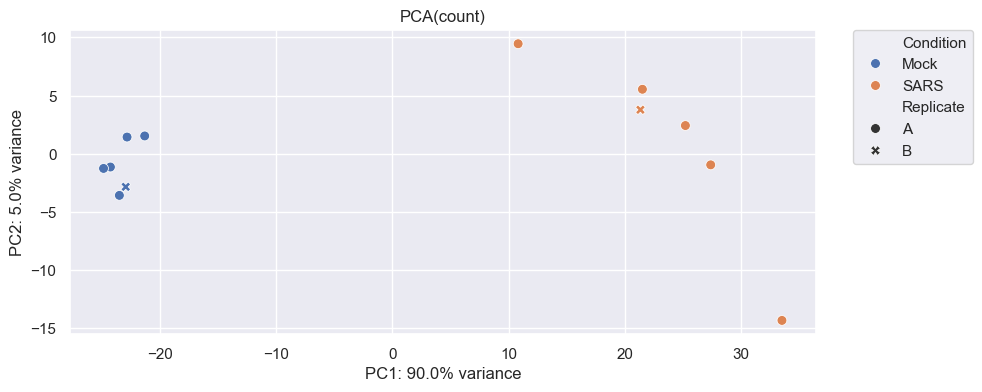

In [52]:
plot_pca(sars)

The samples are colored according to *Condition* (see above in the Coldata table). *Condition* has a special meaning in GrandPy, not only for `plot_pca()`, but also for other analyses (see below). `condition` can be set conveniently using `with_condition()`. For more information, see the [loading data and working with GrandPy objects](../notebook_03_loading_data_and_working_with_grandpy_objects) notebook. For `plot_pca()`, the visual attributes can be adapted via the `aest` parameter:

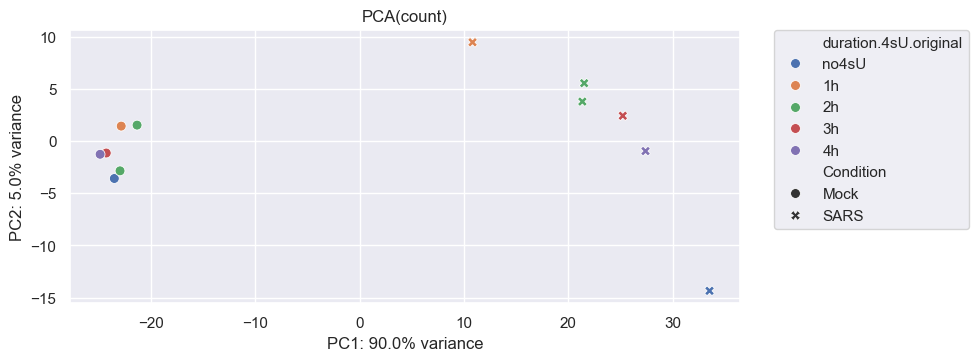

In [53]:
plot_pca(sars, aest={"color": "duration.4sU.original", "shape": "Condition"})

There are no obvious problems with the samples, even though the virus infected no4sU sample is the bottom-most whereas the other virus infected samples are ordered along infection time from bottom to top.

For the NLLS approach it is important to normalize the data:

In [54]:
sars = sars.normalize()
print(sars)

GrandPy:
Read from C:\Users\user\AppData\Local\Temp\tmpg5uph0pb\sars.tsv.gz
9162 genes, 12 samples/cells
Available data slots: ['ntr', 'alpha', 'beta', 'count', 'norm']
Available analyses: []
Available plots: {}
Default data slot: norm



Make sure that the normalization you use here is appropriate. Calling `normalize()` will add a slot which is set to be the default slot.

Before we estimate kinetic parameters globally, we inspect an example:

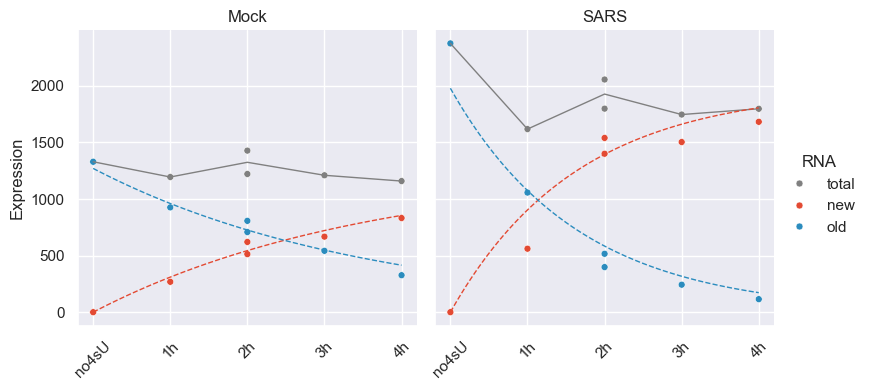

In [55]:
plot_gene_progressive_timecourse(sars, "SRSF6")

The curves represent the fitted model for this gene. The kinetic modeling by default makes the assumption of steady state gene expression, i.e. that as much RNA is transcribed per time unit as it is degraded. In mathematical terms, it is

$$\frac{da}{dt} = \sigma - \delta \cdot a(t) \quad \Leftrightarrow \quad a(t) = \frac{\sigma}{\delta}$$

For the virus infected samples (“SARS”), this is not the case. So we specify an additional parameter:

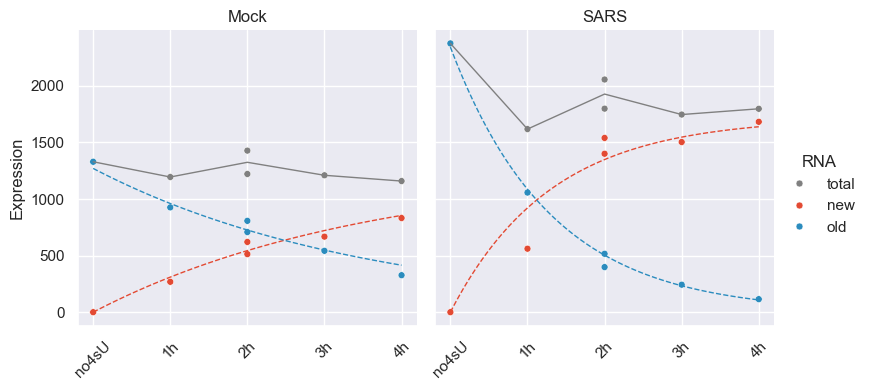

In [56]:
plot_gene_progressive_timecourse(sars, "SRSF6", steady_state={"Mock": True, "SARS": False})

Note that the fit actually changed. Now we are ready to fit the model for each gene. For that we take a closer look at `fit_kinetics()`.

By default, `fit_kinetics()` will run in parallel if the dataset is large enough. This can be controlled via the `max_processes` and `exact_processes` parameter.

`max_processes` defines the maximum number of worker processes (typically corresponding to CPU cores) that the method can use. `exact_processes` defines, whether to use exactly `max_processes`. If set to `True`, the specified number of processes will be launched, regardless of the workload. If it is set to `False`, the number of processes is adjusted dynamically based on the system's number of cores and the size of the task (This is a rough estimate and might not be optimal, depending on the specific system).

In [57]:
sars = sars.fit_kinetics(steady_state={"Mock": True, "SARS": False}, max_processes=6)

Fitting SARS: 100%|██████████| 9162/9162 [00:12<00:00, 739.89it/s] 


`fit_kinetics()` added its result to the GrandPy object.

In [58]:
print(sars)

GrandPy:
Read from C:\Users\user\AppData\Local\Temp\tmpg5uph0pb\sars.tsv.gz
9162 genes, 12 samples/cells
Available data slots: ['ntr', 'alpha', 'beta', 'count', 'norm']
Available analyses: ['kinetics_Mock', 'kinetics_SARS']
Available plots: {}
Default data slot: norm



Note that there are now two analysis tables. We can get more information using `get_analyses()`:

In [59]:
sars.get_analyses(description=True)

{'kinetics_Mock': ['Mock_Synthesis', 'Mock_Half-life'],
 'kinetics_SARS': ['SARS_Synthesis', 'SARS_Half-life']}

This tells us that the two analysis tables, each have a *Synthesis* and a *Half-life* column. We can retrieve the analysis results using the `get_analysis_table()` method. Here it is important to note, that *Half-life* is provided in hours and *Synthesis* in new count per hour.

In [60]:
sars.get_analysis_table().head()

,Symbol,Gene,Length,Type,Mock_Synthesis,Mock_Half-life,SARS_Synthesis,SARS_Half-life
Symbol,,,,,,,,
MIB2,MIB2,ENSG00000197530,4247,Cellular,11.450151,6.685994,37.361605,4.663986
OSBPL9,OSBPL9,ENSG00000117859,4520,Cellular,34.006665,8.918748,100.077066,2.088027
BTF3L4,BTF3L4,ENSG00000134717,4703,Cellular,75.250352,4.452954,98.585069,2.074247
ZFYVE9,ZFYVE9,ENSG00000157077,5194,Cellular,22.187599,5.119376,49.949049,2.259194
PRPF38A,PRPF38A,ENSG00000134748,5274,Cellular,84.612517,2.890793,204.611036,0.938267


See the [working with data matrices and analysis results](../notebook_04_working_with_data_matrices_and_analysis_results) notebook for more information on how to retrieve data from the GrandPy object.

We can use the `plot_scatter()` function to compare half-lifes from 'Mock' and 'SARS'.

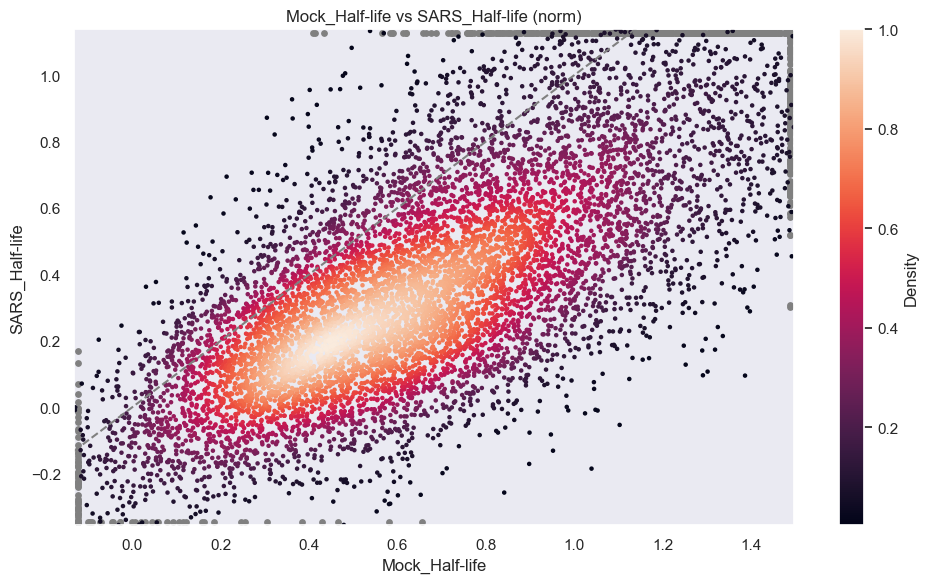

In [61]:
gp.plot_scatter(sars, x="Mock_Half-life", y="SARS_Half-life",log=True, diagonal=True)

For more on `plot_scatter()`, see the [plotting notebook](../notebook_05_plotting). `fit_kinetics()` can actually compute much more information. To see this, let's look at the `return_fields` parameter.

In [62]:
small_sars = sars[0:100] # Only use the first 100 genes for faster computation

small_sars = small_sars.fit_kinetics(steady_state={"Mock": True, "SARS": False}, return_fields=["Synthesis", "Degradation", "Half-life", "log_likelihood", "f0", "total", "conf_lower", "conf_upper", "rmse"], show_progress=False)

print(small_sars.get_analyses(description=True))

{'kinetics_Mock': ['Mock_Synthesis', 'Mock_Degradation', 'Mock_Half-life', 'Mock_log_likelihood', 'Mock_f0', 'Mock_total', 'Mock_conf_lower_Synthesis', 'Mock_conf_lower_Degradation', 'Mock_conf_lower_Half-life', 'Mock_conf_upper_Synthesis', 'Mock_conf_upper_Degradation', 'Mock_conf_upper_Half-life', 'Mock_rmse'], 'kinetics_SARS': ['SARS_Synthesis', 'SARS_Degradation', 'SARS_Half-life', 'SARS_log_likelihood', 'SARS_f0', 'SARS_total', 'SARS_conf_lower_Synthesis', 'SARS_conf_lower_Degradation', 'SARS_conf_lower_Half-life', 'SARS_conf_upper_Synthesis', 'SARS_conf_upper_Degradation', 'SARS_conf_upper_Half-life', 'SARS_rmse']}


We could also extract the residuals from the model fit. For this we go back to the entire dataset. Note that our previous fit result will be overwritten. This could be prevented by setting the `name_prefix` parameter.

In [63]:
sars = sars.fit_kinetics(steady_state={"Mock": True, "SARS": False}, return_fields="residuals")
print(sars.get_analyses(description=True))

Fitting SARS: 100%|██████████| 9162/9162 [00:13<00:00, 659.31it/s] 


{'kinetics_Mock': ['Mock_no4sU_A_residuals_absolute_old', 'Mock_1h_A_residuals_absolute_old', 'Mock_2h_A_residuals_absolute_old', 'Mock_2h_B_residuals_absolute_old', 'Mock_3h_A_residuals_absolute_old', 'Mock_4h_A_residuals_absolute_old', 'Mock_no4sU_A_residuals_absolute_new', 'Mock_1h_A_residuals_absolute_new', 'Mock_2h_A_residuals_absolute_new', 'Mock_2h_B_residuals_absolute_new', 'Mock_3h_A_residuals_absolute_new', 'Mock_4h_A_residuals_absolute_new', 'Mock_no4sU_A_residuals_relative_old', 'Mock_1h_A_residuals_relative_old', 'Mock_2h_A_residuals_relative_old', 'Mock_2h_B_residuals_relative_old', 'Mock_3h_A_residuals_relative_old', 'Mock_4h_A_residuals_relative_old', 'Mock_no4sU_A_residuals_relative_new', 'Mock_1h_A_residuals_relative_new', 'Mock_2h_A_residuals_relative_new', 'Mock_2h_B_residuals_relative_new', 'Mock_3h_A_residuals_relative_new', 'Mock_4h_A_residuals_relative_new'], 'kinetics_SARS': ['SARS_no4sU_A_residuals_absolute_old', 'SARS_1h_A_residuals_absolute_old', 'SARS_2h_A_

Let's plot the distribution of relative residuals for new RNA.

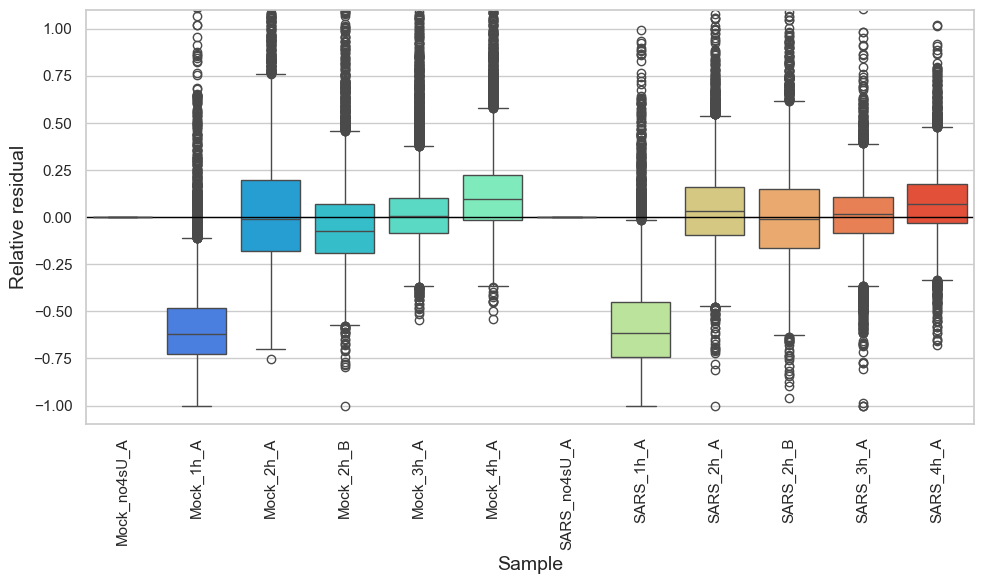

In [64]:
df = sars.get_analysis_table(columns=["relative_new"], with_gene_info=False)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df.columns = df.columns.str.replace('_residuals_relative_new', '')

df_melted = pd.melt(df, var_name="Sample", value_name="Relative residual")

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

sns.boxplot(data=df_melted, x='Sample', y='Relative residual', palette='rainbow')

plt.axhline(0, color='black', linewidth=1)

plt.xticks(rotation=90)

plt.ylim(-1.1, 1.1)

plt.xlabel('Sample', fontsize=14)
plt.ylabel('Relative residual', fontsize=14)

plt.tight_layout()
plt.show()

We see that the residuals from the 1h timepoints are systematically below zero. An example of this is 'SMAD3':

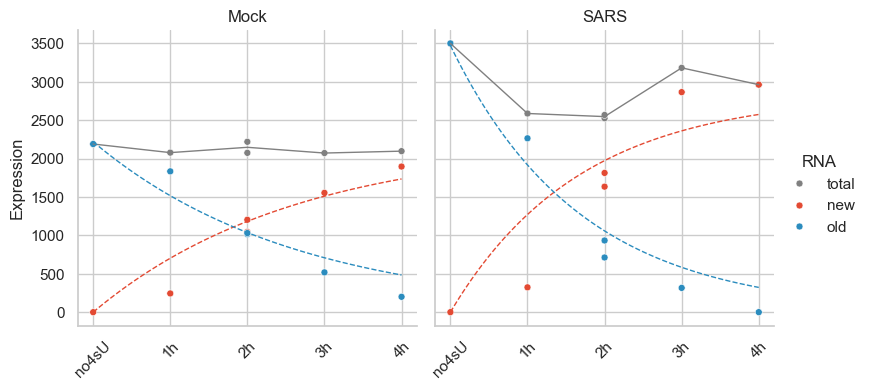

In [65]:
plot_gene_progressive_timecourse(sars, "SMAD3", steady_state={"Mock": True, "SARS": False})

For both 'Mock' and 'SARS', we see that new RNA from 1h is well below the model fit, i.e. has negative residual. This indicates that the effective labeling time was much lower than the nominal labeling time of 1h for these samples, i.e. that actually, these samples should move to the left. This can be rectified by temporal recalibration:

In [66]:
# This takes a long time to compute properly, so we just take the 10 top expressed genes here for a rough estimate.
sars = sars.calibrate_effective_labeling_time_kinetic_fit(steady_state={"Mock": True, "SARS": False}, n_top_genes=10)

Optimizing Mock: 153 Iterations [00:22,  6.94 Iterations/s]
Optimizing SARS: 175 Iterations [00:18,  9.22 Iterations/s]


This adds the column *calibrated_time* to the `coldata`.

In [67]:
sars.coldata

,Name,Condition,duration.4sU,duration.4sU.original,Replicate,no4sU,calibrated_time
Name,,,,,,,
Mock.no4sU.A,Mock.no4sU.A,Mock,0.0,no4sU,A,True,0.000000
Mock.1h.A,Mock.1h.A,Mock,1.0,1h,A,False,0.432034
Mock.2h.A,Mock.2h.A,Mock,2.0,2h,A,False,1.723929
Mock.2h.B,Mock.2h.B,Mock,2.0,2h,B,False,1.696615
Mock.3h.A,Mock.3h.A,Mock,3.0,3h,A,False,2.793418
Mock.4h.A,Mock.4h.A,Mock,4.0,4h,A,False,4.000000
SARS.no4sU.A,SARS.no4sU.A,SARS,0.0,no4sU,A,True,0.000000
SARS.1h.A,SARS.1h.A,SARS,1.0,1h,A,False,0.418920
SARS.2h.A,SARS.2h.A,SARS,2.0,2h,A,False,2.436633


This recalibrated time can now be used for fitting:

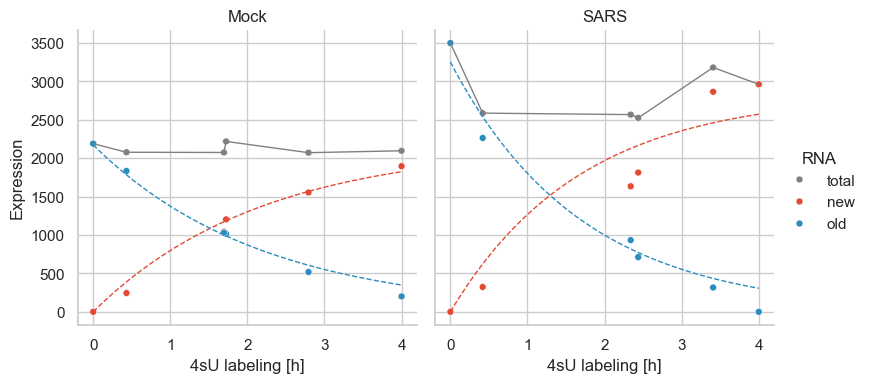

In [68]:
plot_gene_progressive_timecourse(sars, "SMAD3", steady_state={"Mock": True, "SARS": False}, time="calibrated_time", exact_tics=False)

In [69]:
sars = sars.fit_kinetics(name_prefix="corrected", time="calibrated_time", steady_state={"Mock": True, "SARS": False}, return_fields="residuals")

Fitting SARS: 100%|██████████| 9162/9162 [00:12<00:00, 735.93it/s] 


This indeed corrected the residuals:

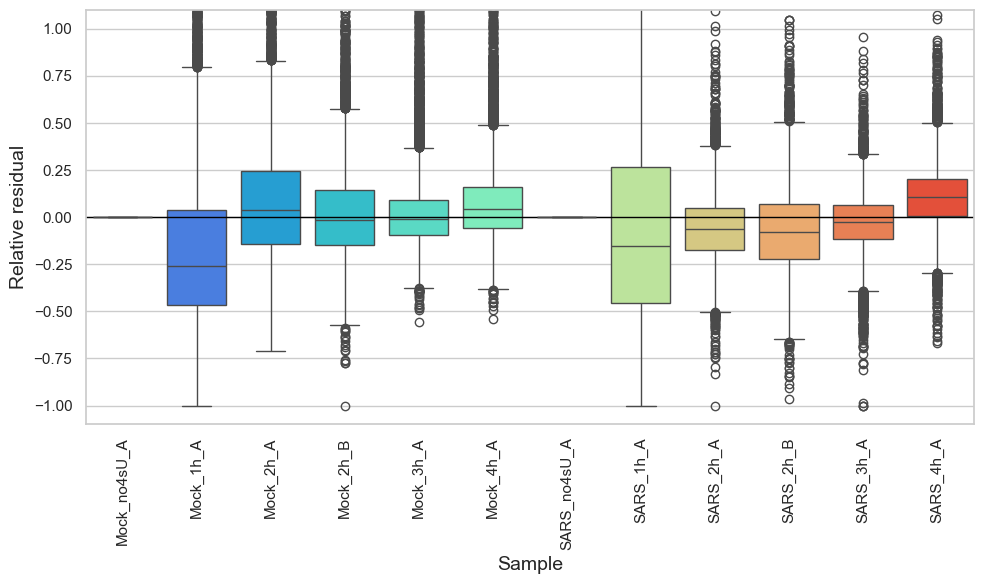

In [70]:
df = sars.get_analysis_table(columns=["corrected.*relative_new"], with_gene_info=False)

df.columns = df.columns.str.replace('_residuals_relative_new', '')
df.columns = df.columns.str.replace('corrected_', '')

df_melted = pd.melt(df, var_name="Sample", value_name="Relative residual")

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

sns.boxplot(data=df_melted, x='Sample', y='Relative residual', palette='rainbow')

plt.axhline(0, color='black', linewidth=1)

plt.xticks(rotation=90)

plt.ylim(-1.1, 1.1)

plt.xlabel('Sample', fontsize=14)
plt.ylabel('Relative residual', fontsize=14)

plt.tight_layout()
plt.show()